In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import torch
from torch.utils.data import DataLoader

/home/yhuang2/.conda/envs/ddpm_torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
%load_ext autoreload
%autoreload 2
from ddpm_tutorial.dataset_toyzero import Toyzero
from ddpm_tutorial.ddpm import DDPM
from ddpm_tutorial.unet import Unet
from ddpm_translate import DDPMTranslate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
CKPT_DIR = Path("./checkpoints/")
IMG_DIR = Path("./images/toyzero_normalized_translation/")

In [31]:
epoch = 99
encoder_ckpt = CKPT_DIR/f'toyzero_normalized-100_fake/epc_{epoch}.pt'
decoder_ckpt = CKPT_DIR/f'toyzero_normalized-100_real/epc_{epoch}.pt'

In [7]:
TOYZERO_DIR = Path('/data/datasets/LS4GAN/toy-adc_256x256_precropped')
batch_size = 4
data_fake = Toyzero(TOYZERO_DIR, partition='test', domain='fake', shuffle=False)
data_real = Toyzero(TOYZERO_DIR, partition='test', domain='real', shuffle=False)
dlr_fake = DataLoader(data_fake, batch_size, num_workers=8)
dlr_real = DataLoader(data_real, batch_size, num_workers=8)

In [13]:
def plot(fake, tran, real, height=2.5, width=2.5):
    diff = real - tran
    l1 = np.abs(real - tran).mean()
    titles = ['fake', 'tran', 'real', f'L_1={l1:.5f}']
    images = [fake, tran, real, diff]
    vrange = max(max(np.abs(image.min()), np.abs(image.max())) for image in images)
    
    fig, axes = plt.subplots(1, 4, figsize=(width * 4, height))
    
    for image, ax, title in zip(images, axes, titles):    
        
        norm = matplotlib.colors.SymLogNorm(linthresh=0.01, vmin=-vrange, vmax=vrange)
        ax.axis('off')
        ax.set_title(title)
        im = ax.imshow(image, cmap='seismic', norm=norm)
    
    cax = ax.inset_axes([1.1, 0.0, 0.08, 1], transform=ax.transAxes)
    fig.colorbar(im, ax=axes, cax=cax)
    plt.tight_layout()
        
    return fig

In [27]:
iter_fake = iter(dlr_fake)
iter_real = iter(dlr_real)

fake, fake_fname = next(iter_fake)
real, real_fname = next(iter_real)

In [45]:
steps = 25
translator = DDPMTranslate(encoder_ckpt, decoder_ckpt, encode_step=steps, decode_step=steps)
tran = translator.translate(fake.cuda(), record_freq=20)

100%|██████████| 25/25 [00:02<00:00,  8.66it/s]


fake: -0.31000, 0.36000
tran: -0.30018, 0.37610
real: -0.30000, 0.41000

fake: -0.31000, 0.36000
tran: -0.30451, 0.38640
real: -0.30000, 0.42000

fake: -0.60000, 0.66000
tran: -0.52384, 0.62969
real: -0.60000, 0.77000

fake: -0.34000, 0.39000
tran: -0.34529, 0.42871
real: -0.33000, 0.44000



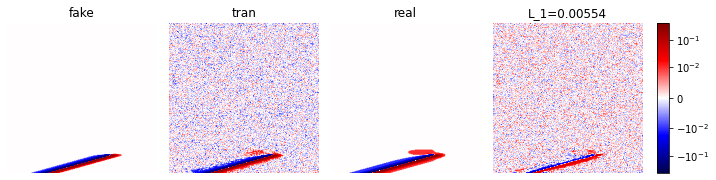

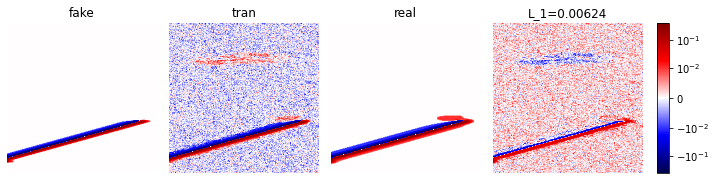

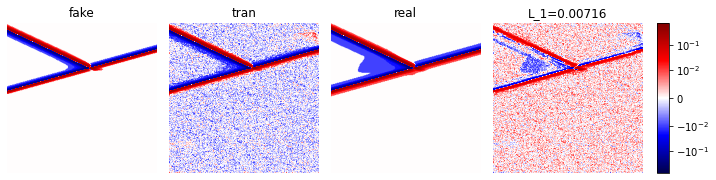

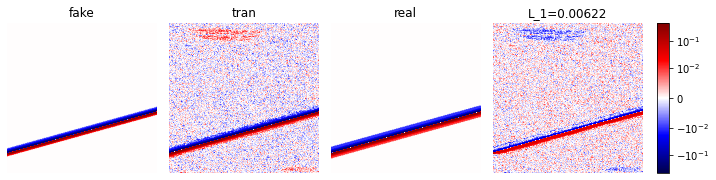

In [46]:
for idx in range(batch_size):
    f_raw = fake[idx].squeeze().numpy()
    f = tran[idx]['input']
    t = tran[idx][0]
    r = real[idx].squeeze().numpy()
    fig = plot(f_raw, t, r)
    fig.savefig(IMG_DIR/f'sample_{idx}_{steps}.png', bbox_inches='tight', transparent=True, dpi=200)
    print(f'fake: {f_raw.min():.5f}, {f_raw.max():.5f}')
    print(f'tran: {t.min():.5f}, {t.max():.5f}')
    print(f'real: {r.min():.5f}, {r.max():.5f}\n')